# Steel Defect Detection: Preprocessing Data + EDA
## Nazih Kalo

<a id="toc"></a>
# Table of Contents
1. [Configure parameters](#configure_parameters)
1. [Import modules](#import_modules)
1. [Draw some charts for input dataset](#draw_some_charts_for_input_dataset)
1. [Split dataset into training and validation sets](#split_dataset_into_training_and_validation_sets)
1. [Visualize some images and corresponding labels](#visualize_some_images_and_corresponding_labels)
1. [Copy images into right folders](#copy_images_into_right_folders)
1. [Zip training and validation sets](#zip_training_and_validation_sets)
1. [Save labels](#save_labels)

<a id="configure_parameters"></a>
# Configure parameters
[Back to Table of Contents](#toc)

In [1]:
DATASET_DIR = '../input/severstal-steel-defect-detection/'
TEST_SIZE = 0.1
RANDOM_STATE = 123

NUM_TRAIN_SAMPLES = 20 # The number of train samples used for visualization
NUM_VAL_SAMPLES = 20 # The number of val samples used for visualization
COLORS = ['b', 'g', 'r', 'm'] # Color of each class

<a id="import_modules"></a>
# Import modules
[Back to Table of Contents](#toc)

In [2]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from shutil import copyfile
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook

In [3]:
df = pd.read_csv(os.path.join(DATASET_DIR, 'train.csv'))

In [4]:
df.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

### The dataset for the competition has changed since its completion so this code is meant to convert the structure of train.csv back to the original format.
##### Convert training data-frame to the legacy version

In [5]:
legacy_df = pd.DataFrame(columns=['ImageId_ClassId', 'EncodedPixels'])

for img_id, img_df in tqdm_notebook(df.groupby('ImageId')):
    for i in range(1, 5):
        avail_classes = list(img_df.ClassId)

        row = dict()
        row['ImageId_ClassId'] = img_id + '_' + str(i)

        if i in avail_classes:
            row['EncodedPixels'] = img_df.loc[img_df.ClassId == i].EncodedPixels.iloc[0]
        else:
            row['EncodedPixels'] = np.nan
        
        legacy_df = legacy_df.append(row, ignore_index=True)

In [6]:
legacy_df.head()

ImageId_ClassId                                      EncodedPixels
0  0002cc93b.jpg_1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0002cc93b.jpg_2                                                NaN
2  0002cc93b.jpg_3                                                NaN
3  0002cc93b.jpg_4                                                NaN
4  0007a71bf.jpg_1                                                NaN

In [7]:
df = legacy_df

##### Continue the preprocessing process

In [8]:
df['Image'] = df['ImageId_ClassId'].map(lambda x: x.split('_')[0])
df['HavingDefection'] = df['EncodedPixels'].map(lambda x: 0 if x is np.nan else 1)

image_col = np.array(df['Image'])
image_files = image_col[::4]
all_labels = np.array(df['HavingDefection']).reshape(-1, 4)

In [9]:
num_img_class_1 = np.sum(all_labels[:, 0])
num_img_class_2 = np.sum(all_labels[:, 1])
num_img_class_3 = np.sum(all_labels[:, 2])
num_img_class_4 = np.sum(all_labels[:, 3])
print('Class 1: {} images'.format(num_img_class_1))
print('Class 2: {} images'.format(num_img_class_2))
print('Class 3: {} images'.format(num_img_class_3))
print('Class 4: {} images'.format(num_img_class_4))

Class 1: 897 images
Class 2: 247 images
Class 3: 5150 images
Class 4: 801 images


<a id="draw_some_charts_for_input_dataset"></a>
# Draw some charts for input dataset
[Back to Table of Contents](#toc)

In [10]:
def plot_figures(
    sizes,
    pie_title,
    start_angle,
    bar_title,
    bar_ylabel,
    labels=('Class 1', 'Class 2', 'Class 3', 'Class 4'),
    colors=None,
    explode=(0, 0, 0, 0.1),
):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    y_pos = np.arange(len(labels))
    barlist = axes[0].bar(y_pos, sizes, align='center')
    axes[0].set_xticks(y_pos, labels)
    axes[0].set_ylabel(bar_ylabel)
    axes[0].set_title(bar_title)
    if colors is not None:
        for idx, item in enumerate(barlist):
            item.set_color(colors[idx])

    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            axes[0].text(
                rect.get_x() + rect.get_width()/2., height,
                '%d' % int(height),
                ha='center', va='bottom', fontweight='bold'
            )

    autolabel(barlist)
    
    pielist = axes[1].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=start_angle, counterclock=False)
    axes[1].axis('equal')
    axes[1].set_title(pie_title)
    if colors is not None:
        for idx, item in enumerate(pielist[0]):
            item.set_color(colors[idx])

    plt.show()

[THE WHOLE DATASET]


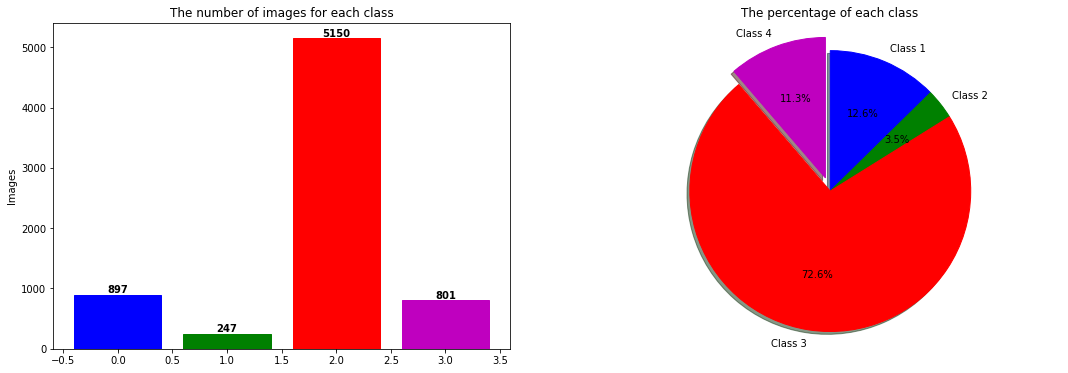

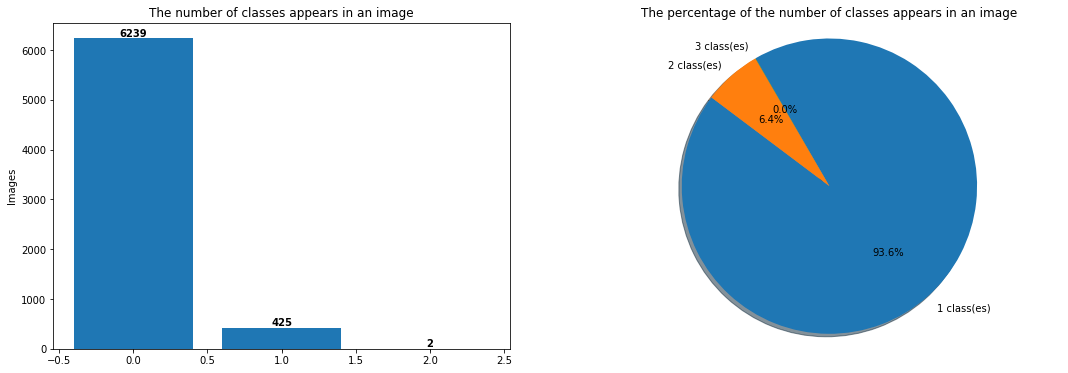

In [11]:
print('[THE WHOLE DATASET]')

sum_each_class = np.sum(all_labels, axis=0)
plot_figures(
    sum_each_class,
    pie_title='The percentage of each class',
    start_angle=90,
    bar_title='The number of images for each class',
    bar_ylabel='Images',
    colors=COLORS,
    explode=(0, 0, 0, 0.1)
)

sum_each_sample = np.sum(all_labels, axis=1)
unique, counts = np.unique(sum_each_sample, return_counts=True)

plot_figures(
    counts,
    pie_title='The percentage of the number of classes appears in an image',
    start_angle=120,
    bar_title='The number of classes appears in an image',
    bar_ylabel='Images',
    labels=[' '.join((str(label), 'class(es)')) for label in unique],
    explode=np.zeros(len(unique))
)

<a id="split_dataset_into_training_and_validation_sets"></a>
# Split dataset into training and validation sets
[Back to Table of Contents](#toc)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(image_files, all_labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [13]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_val:', X_val.shape)
print('y_val:', y_val.shape)

X_train: (5999,)
y_train: (5999, 4)
X_val: (667,)
y_val: (667, 4)


[TRAINING SET]


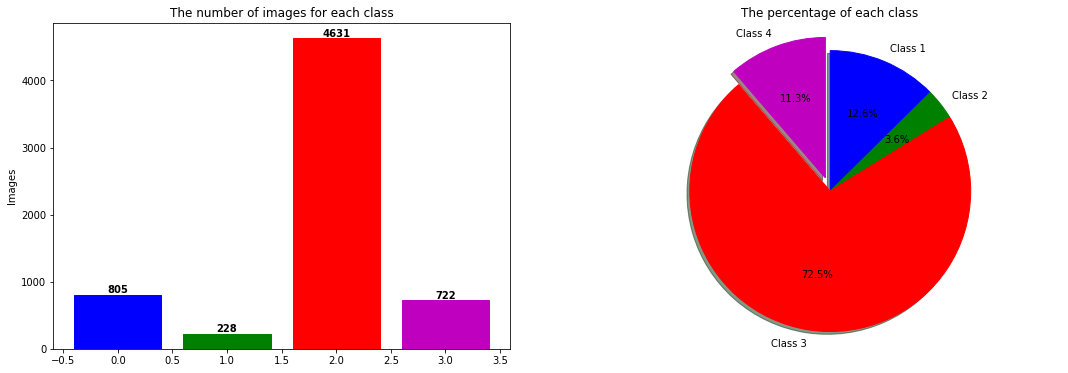

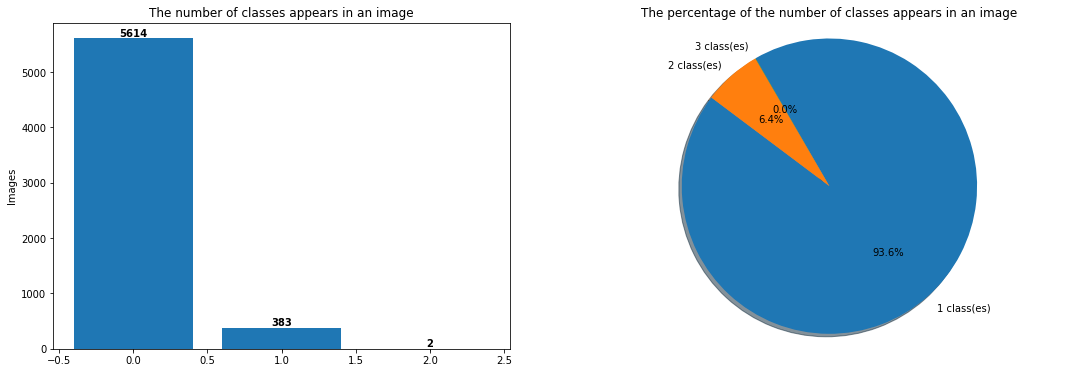

In [14]:
print('[TRAINING SET]')

sum_each_class = np.sum(y_train, axis=0)
plot_figures(
    sum_each_class,
    pie_title='The percentage of each class',
    start_angle=90,
    bar_title='The number of images for each class',
    bar_ylabel='Images',
    colors=COLORS,
    explode=(0, 0, 0, 0.1)
)


sum_each_sample = np.sum(y_train, axis=1)
unique, counts = np.unique(sum_each_sample, return_counts=True)

plot_figures(
    counts,
    pie_title='The percentage of the number of classes appears in an image',
    start_angle=120,
    bar_title='The number of classes appears in an image',
    bar_ylabel='Images',
    labels=[' '.join((str(label), 'class(es)')) for label in unique],
    explode=np.zeros(len(unique))
)

[VALIDATION SET]


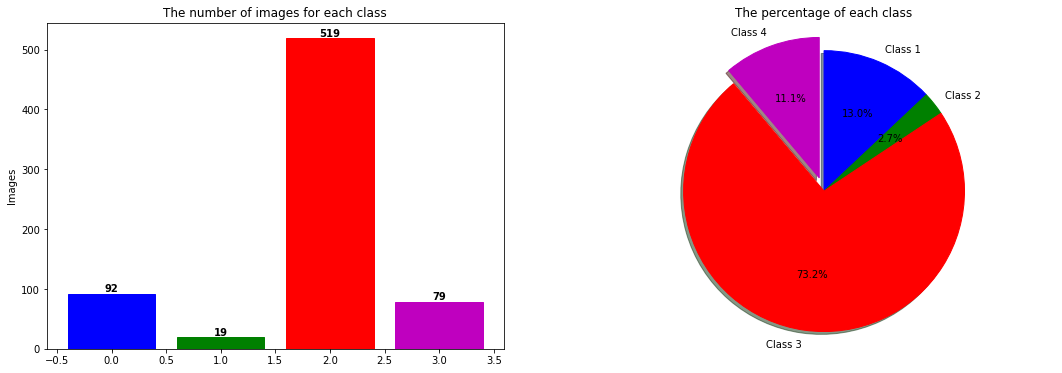

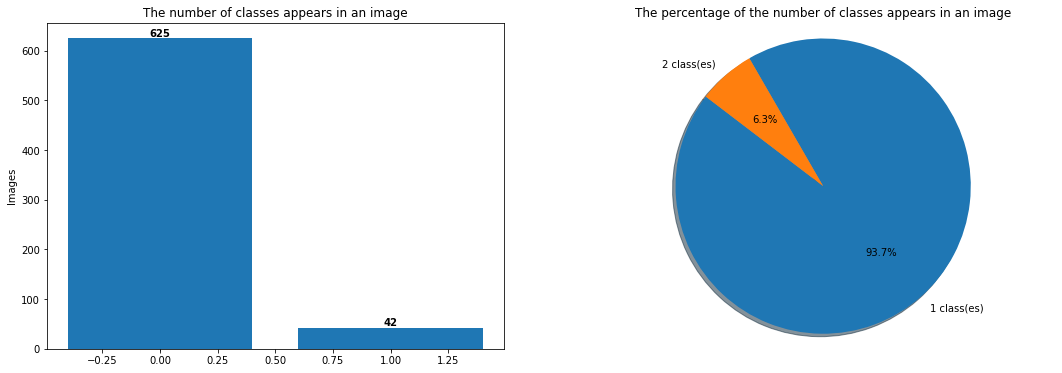

In [15]:
print('[VALIDATION SET]')

sum_each_class = np.sum(y_val, axis=0)
plot_figures(
    sum_each_class,
    pie_title='The percentage of each class',
    start_angle=90,
    bar_title='The number of images for each class',
    bar_ylabel='Images',
    colors=COLORS,
    explode=(0, 0, 0, 0.1)
)


sum_each_sample = np.sum(y_val, axis=1)
unique, counts = np.unique(sum_each_sample, return_counts=True)

plot_figures(
    counts,
    pie_title='The percentage of the number of classes appears in an image',
    start_angle=120,
    bar_title='The number of classes appears in an image',
    bar_ylabel='Images',
    labels=[' '.join((str(label), 'class(es)')) for label in unique],
    explode=np.zeros(len(unique))
)

<a id="visualize_some_images_and_corresponding_labels"></a>
# Visualize some images and corresponding labels
[Back to Table of Contents](#toc)

In [16]:
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [17]:
def show_samples(samples):
    for sample in samples:
        fig, ax = plt.subplots(figsize=(15, 10))
        img_path = os.path.join(DATASET_DIR, 'train_images', sample[0])
        img = cv2.imread(img_path)

        # Get annotations
        labels = df[df['ImageId_ClassId'].str.contains(sample[0])]['EncodedPixels']

        patches = []
        for idx, rle in enumerate(labels.values):
            if rle is not np.nan:
                mask = rle2mask(rle)
                contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                for contour in contours:
                    poly_patch = Polygon(contour.reshape(-1, 2), closed=True, linewidth=1, edgecolor=COLORS[idx], fill=False)
                    patches.append(poly_patch)
        p = PatchCollection(patches, match_original=True, cmap=matplotlib.cm.jet)

        ax.imshow(img/255)
        ax.set_title('{} - ({})'.format(sample[0], ', '.join(sample[1].astype(np.str))))
        ax.add_collection(p)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.show()

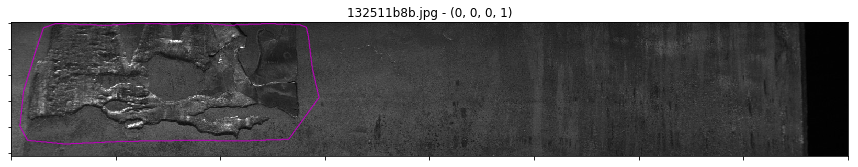

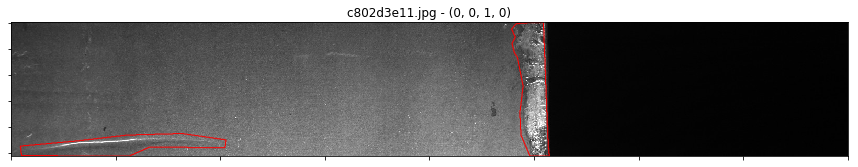

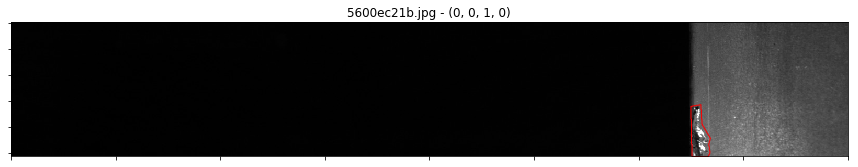

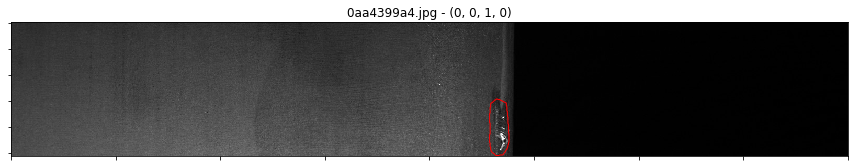

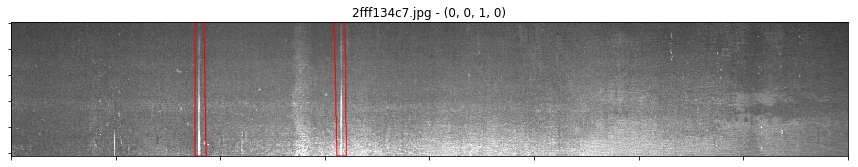

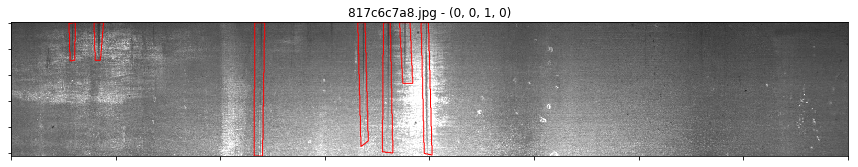

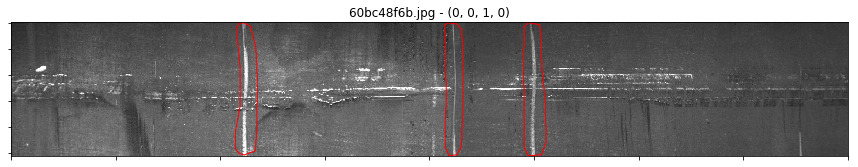

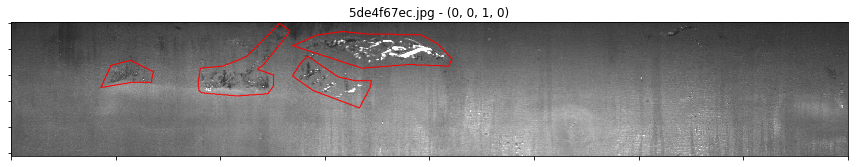

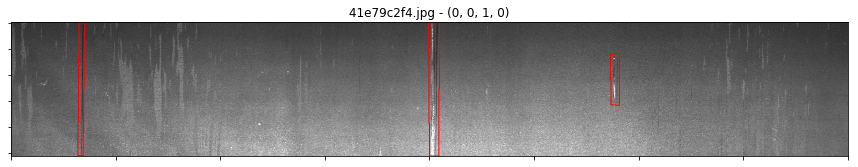

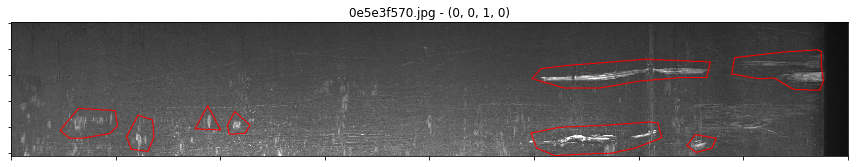

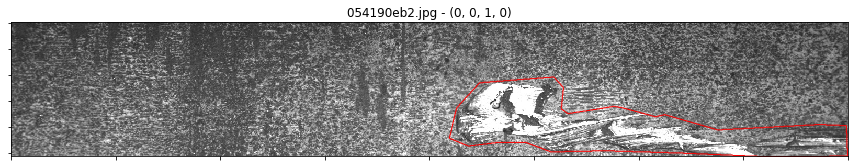

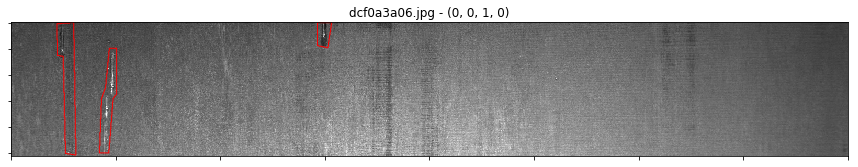

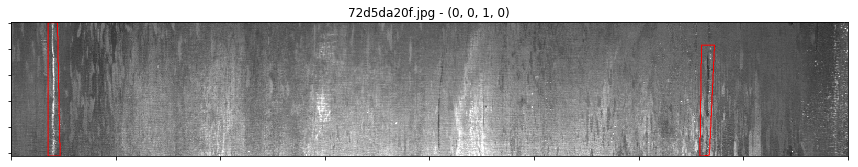

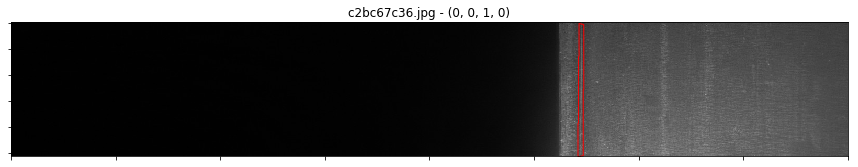

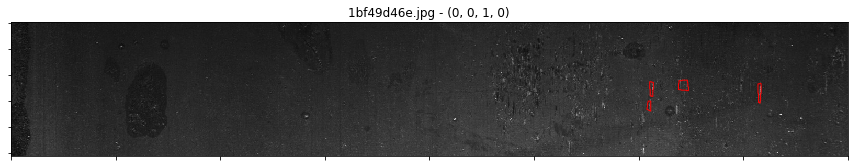

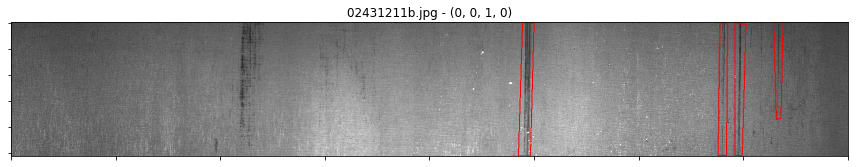

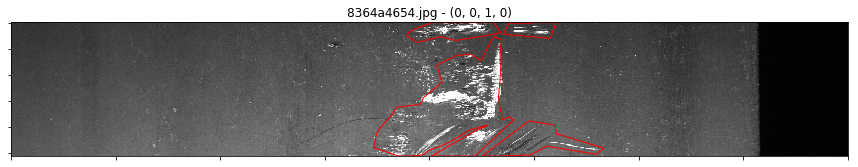

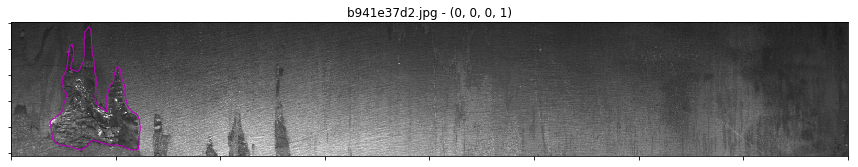

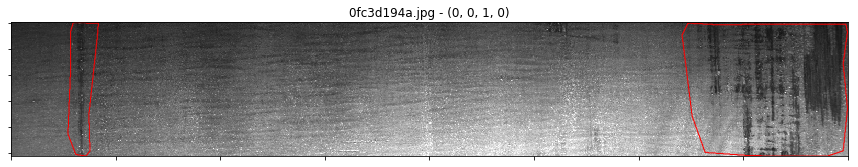

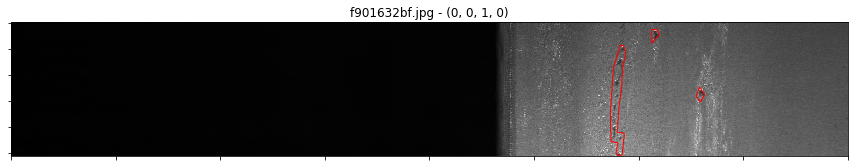

In [18]:
train_pairs = np.array(list(zip(X_train, y_train)))
train_samples = train_pairs[np.random.choice(train_pairs.shape[0], NUM_TRAIN_SAMPLES, replace=False), :]

show_samples(train_samples)

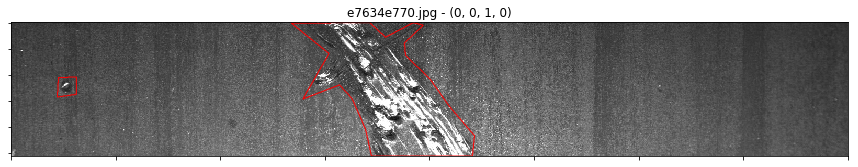

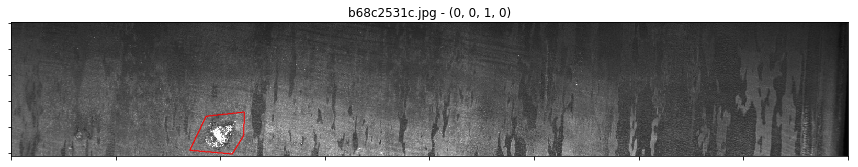

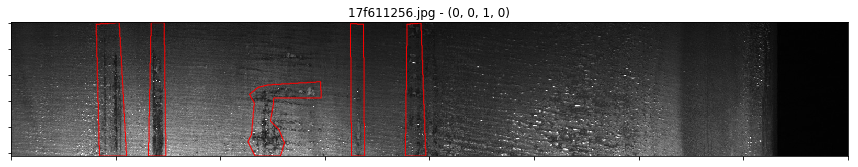

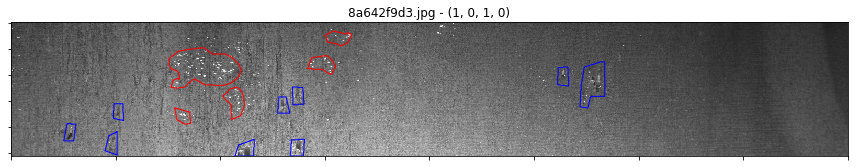

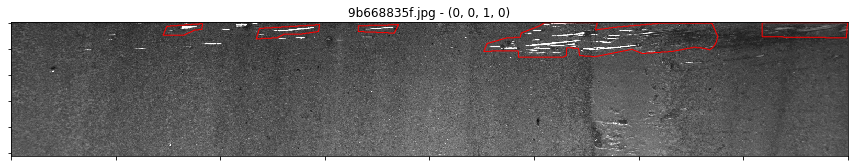

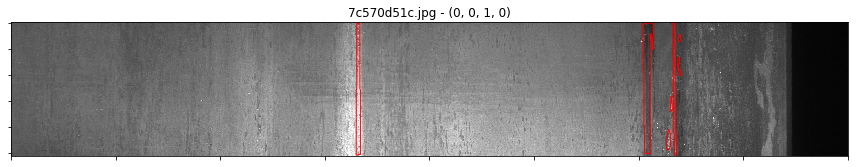

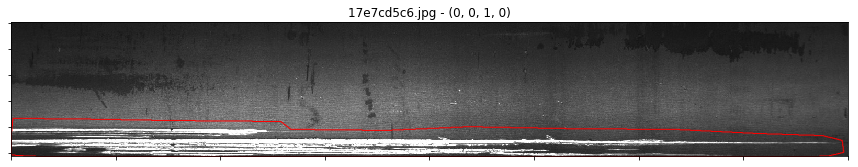

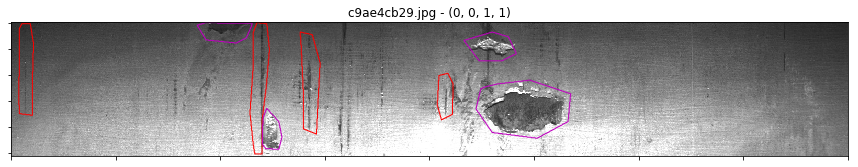

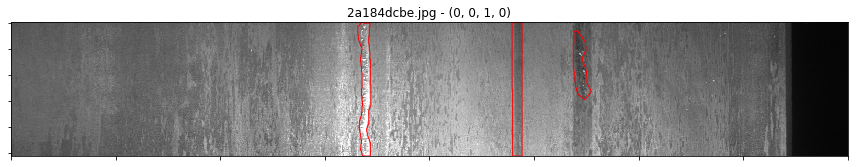

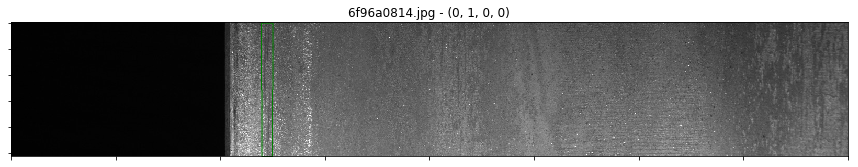

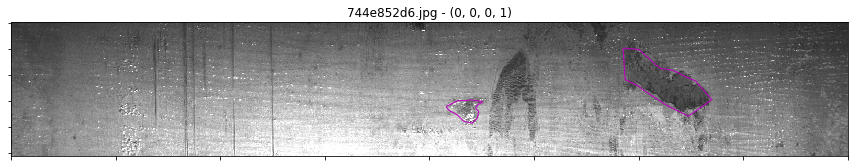

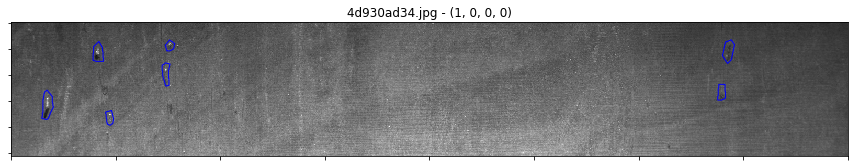

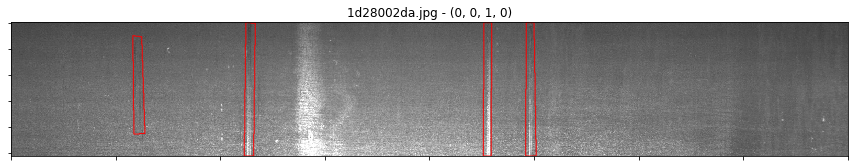

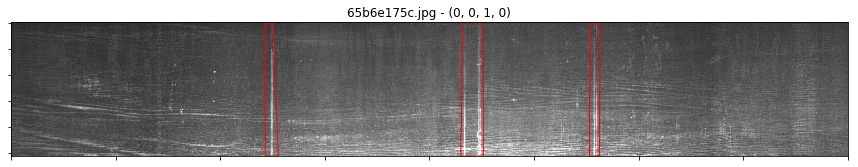

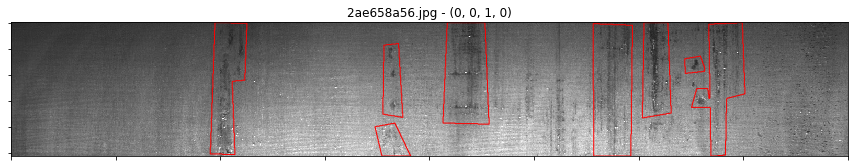

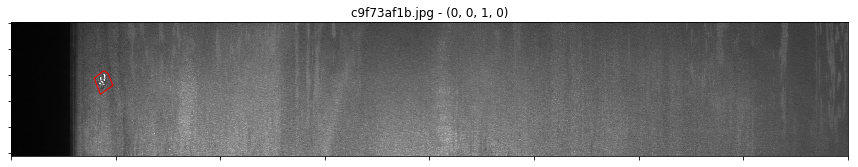

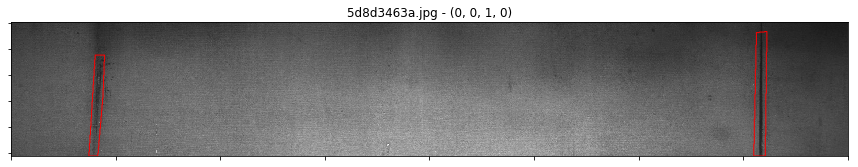

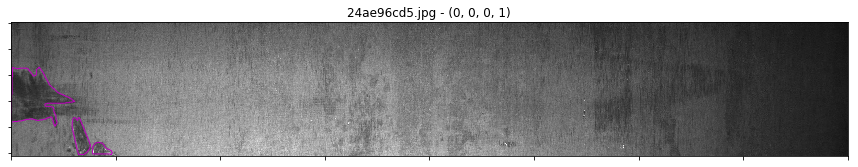

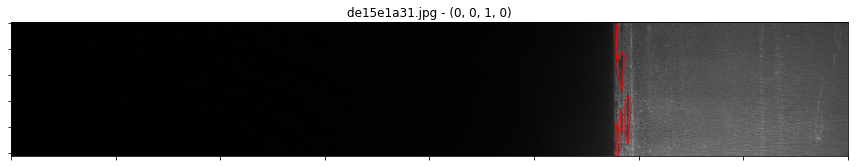

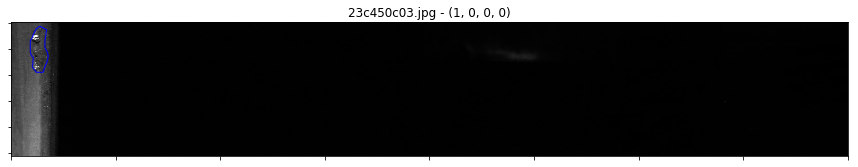

In [19]:
val_pairs = np.array(list(zip(X_val, y_val)))
val_samples = val_pairs[np.random.choice(val_pairs.shape[0], NUM_VAL_SAMPLES, replace=False), :]

show_samples(val_samples)

<a id="copy_images_into_right_folders"></a>
# Copy images into right folders
[Back to Table of Contents](#toc)

In [25]:
!mkdir train_images
!mkdir val_images

In [26]:
for image_file in tqdm_notebook(X_train):
    src = os.path.join(DATASET_DIR, 'train_images', image_file)
    dst = os.path.join('./train_images', image_file)
    copyfile(src, dst)

for image_file in tqdm_notebook(X_val):
    src = os.path.join(DATASET_DIR, 'train_images', image_file)
    dst = os.path.join('./val_images', image_file)
    copyfile(src, dst)

<a id="zip_training_and_validation_sets"></a>
# Zip training and validation sets
[Back to Table of Contents](#toc)

In [27]:
!apt install zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  zip
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 234 kB of archives.
After this operation, 623 kB of additional disk space will be used.
Get:1 http://deb.debian.org/debian stretch/main amd64 zip amd64 3.0-11+b1 [234 kB]
Fetched 234 kB in 0s (2238 kB/s)m
debconf: delaying package configuration, since apt-utils is not installed

78Selecting previously unselected package zip.
(Reading database ... 58908 files and directories currently installed.)
Preparing to unpack .../zip_3.0-11+b1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 16%] [#########.................................................] 8Unpacking zip (3.0-11+b1) ...
7Progress: [ 33%] [###################.......................................] 87Progress: [ 50%] [###########################

In [28]:
!zip -r -m -1 -q train_images.zip ./train_images
!zip -r -m -1 -q val_images.zip ./val_images

In [29]:
y_train = [' '.join(y.astype(np.str)) for y in y_train]
y_val = [' '.join(y.astype(np.str)) for y in y_val]

In [30]:
print(len(y_train))
print(len(y_val))

5999
667


<a id="save_labels"></a>
# Save labels
[Back to Table of Contents](#toc)

In [31]:
train_set = {
    'ImageId': X_train,
    'Label': y_train
}

val_set = {
    'ImageId': X_val,
    'Label': y_val
}

train_df = pd.DataFrame(train_set)
val_df = pd.DataFrame(val_set)

train_df.to_csv('./train.csv', index=False)
val_df.to_csv('./val.csv', index=False)